In [2]:
import matplotlib.pyplot as plt
import requests
import pandas as pd


## EDA with data sample

In [3]:
#df = pd.read_csv('rs_100000_2017_to_present.csv')
df = pd.read_csv('/Applications/Documents/Uchicago/2023_2024/1_Math_Foundations_ML/project/rs_million.csv')

df.columns


Index(['trip_id', 'start_time', 'stop_time', 'bike_id', 'trip_duration',
       'from_station_id', 'from_station_name', 'to_station_id',
       'to_station_name', 'user_type', 'gender', 'birth_year', 'from_latitude',
       'from_longitude', 'from_location', 'to_latitude', 'to_longitude',
       'to_location'],
      dtype='object')

In [9]:
# format timestamp as a date
df['start_time_dt_fmt'] = pd.to_datetime(df['start_time'], format='%Y-%m-%dT%H:%M:%S.%f')

# new columns for month-year, year parts, time, etc
df['month_year'] = df['start_time_dt_fmt'].dt.to_period('M')
df['year'] = df['start_time_dt_fmt'].dt.year
df['quarter'] = df['start_time_dt_fmt'].dt.to_period('Q')
df['month'] = df['start_time_dt_fmt'].dt.month
df['hour'] = df['start_time_dt_fmt'].dt.hour
df['min'] = df['start_time_dt_fmt'].dt.minute
df['time_in_hours'] = df['hour'] + df['min']/60

df['trip_duration_min'] = df['trip_duration']/60


In [5]:
# Remove outlier option 1: 20* IQR
def remove_outliers(group):
    Q1 = group['trip_duration_min'].quantile(0.25)
    Q3 = group['trip_duration_min'].quantile(0.75)
    IQR = Q3 - Q1
    return group[(group['trip_duration_min'] >= Q1 - 20 * IQR) & (group['trip_duration_min'] <= Q3 + 20 * IQR)]

df_no_outliers = df.groupby('year').apply(remove_outliers)

# Remove outlier option 2: filter out anything over 10 hours 
df_no_outliers = df[df['trip_duration_min'] <= (60 * 10)]

print(df_no_outliers['trip_duration_min'].describe())
df['trip_duration_min'].describe()


count    999191.000000
mean         16.830638
std          21.086799
min           1.000000
25%           6.850000
50%          11.766667
75%          20.133333
max         599.833333
Name: trip_duration_min, dtype: float64


count    1000000.000000
mean          18.789552
std          221.125884
min            1.000000
25%            6.850000
50%           11.783333
75%           20.166667
max       116647.166667
Name: trip_duration_min, dtype: float64

In [10]:
# Identify the top ten stations by the number of trips
top_stations = df_no_outliers['from_station_name'].value_counts().nlargest(10).index
df_no_outliers['from_station_name'].value_counts().nlargest(10)

from_station_name
Streeter Dr & Grand Ave         15196
Lake Shore Dr & Monroe St       13271
Clinton St & Washington Blvd    12735
Canal St & Adams St             12716
Theater on the Lake             11140
Clinton St & Madison St         10962
Lake Shore Dr & North Blvd      10667
Michigan Ave & Oak St           10174
Millennium Park                  9787
Canal St & Madison St            9383
Name: count, dtype: int64

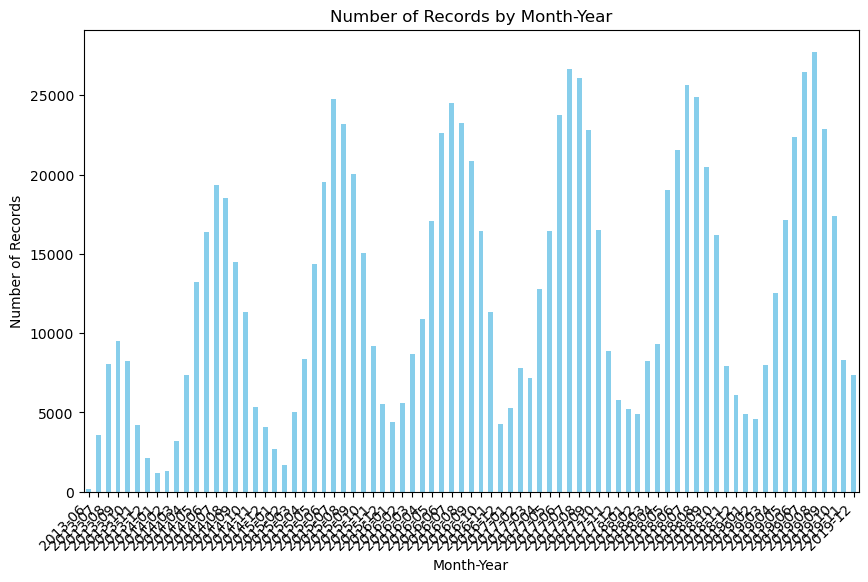

In [6]:
# Coverage of data

# Group by 'month_year' and count the number of records
monthly_counts = df['month_year'].value_counts().sort_index()

# Plot the number of records by month-year
plt.figure(figsize=(10, 6))
monthly_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Records by Month-Year')
plt.xlabel('Month-Year')
plt.ylabel('Number of Records')
plt.xticks(rotation=45, ha='right')
plt.show()

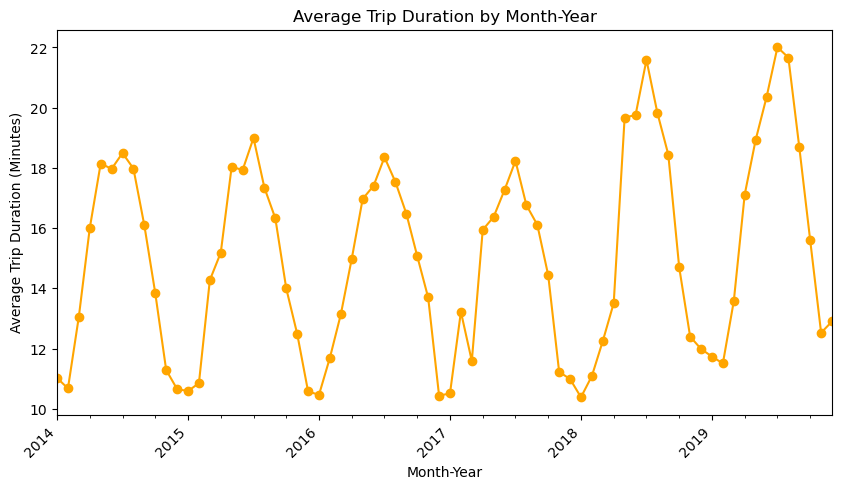

In [7]:
# Group by 'month_year' and calculate the average trip duration
df_no_outliers = df_no_outliers.loc[df_no_outliers['year']>=2014]
monthly_avg_duration = df_no_outliers.groupby('month_year')['trip_duration_min'].mean()

# Plot the average trip duration by month-year
plt.figure(figsize=(10, 5))
monthly_avg_duration.plot(kind='line', marker='o', color='orange')
plt.title('Average Trip Duration by Month-Year')
plt.xlabel('Month-Year')
plt.ylabel('Average Trip Duration (Minutes)')
plt.xticks(rotation=45, ha='right')
plt.show()

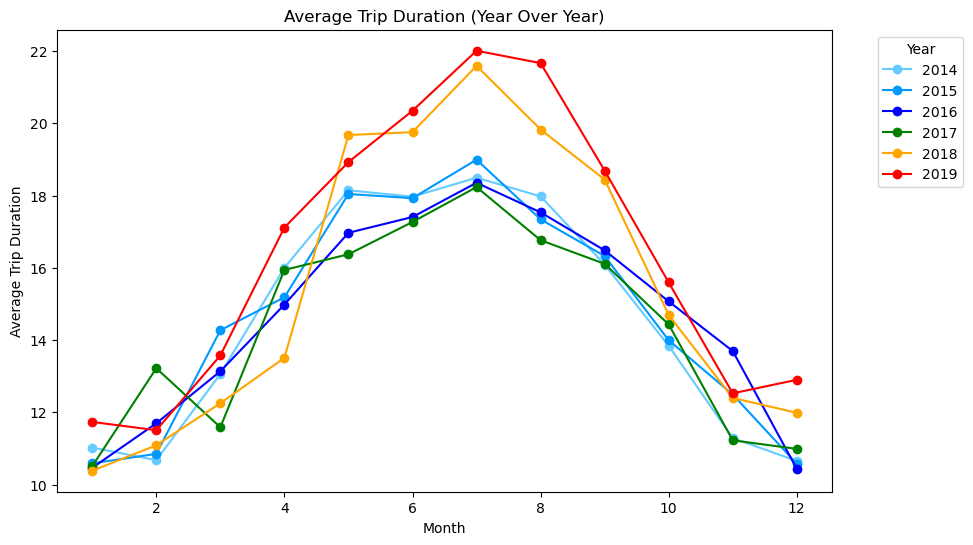

In [8]:
# calculate the average trip duration YOY

yearly_avg_duration = df_no_outliers.groupby(['year', 'month'])['trip_duration_min'].mean().reset_index()

plt.figure(figsize=(10, 6))

year_data = yearly_avg_duration[yearly_avg_duration['year'] == 2014]
plt.plot(year_data['month'], year_data['trip_duration_min'], label='2014', marker='o', color ='#66CCFF' )

year_data = yearly_avg_duration[yearly_avg_duration['year'] == 2015]
plt.plot(year_data['month'], year_data['trip_duration_min'], label='2015', marker='o', color ='#0099FF')

year_data = yearly_avg_duration[yearly_avg_duration['year'] == 2016]
plt.plot(year_data['month'], year_data['trip_duration_min'], label='2016', marker='o', color ='blue')

year_data = yearly_avg_duration[yearly_avg_duration['year'] == 2017]
plt.plot(year_data['month'], year_data['trip_duration_min'], label='2017', marker='o', color ='green')

year_data = yearly_avg_duration[yearly_avg_duration['year'] == 2018]
plt.plot(year_data['month'], year_data['trip_duration_min'], label='2018', marker='o', color ='orange')

year_data = yearly_avg_duration[yearly_avg_duration['year'] == 2019]
plt.plot(year_data['month'], year_data['trip_duration_min'], label='2019', marker='o', color ='#FF0000')


plt.title('Average Trip Duration (Year Over Year)')
plt.xlabel('Month')
plt.ylabel('Average Trip Duration')
#plt.xticks(rotation=45, ha='right')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

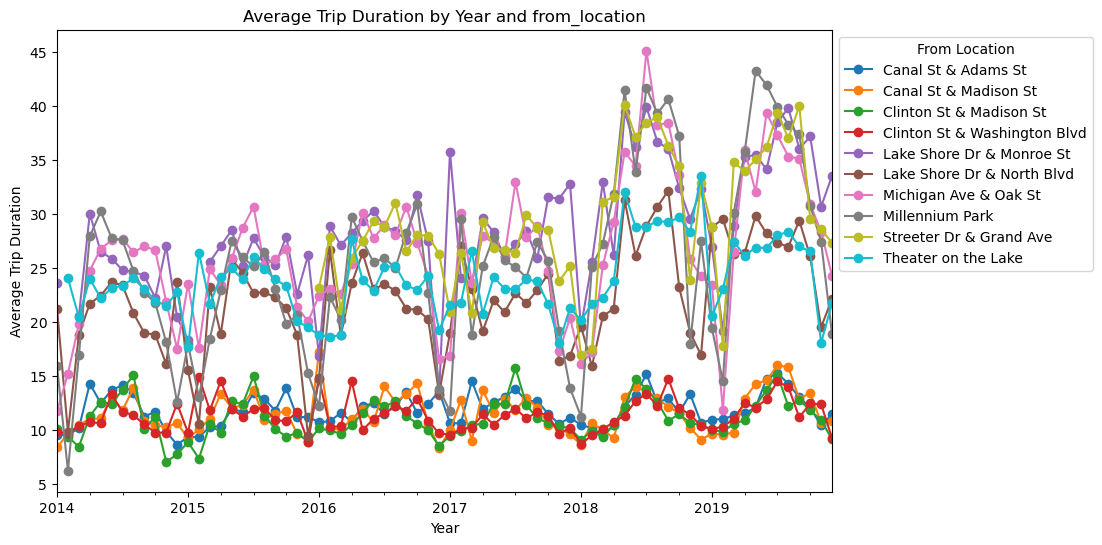

In [12]:

# Filter the DataFrame to include only the top ten stations
df_top_stations = df_no_outliers[df_no_outliers['from_station_name'].isin(top_stations)]

grouped_data = df_top_stations.groupby(['from_station_name', 'month_year'])['trip_duration_min'].mean().reset_index()

pivot_data = grouped_data.pivot(index='month_year', columns='from_station_name', values='trip_duration_min')

pivot_data.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Average Trip Duration by Year and from_location')
plt.xlabel('Year')
plt.ylabel('Average Trip Duration')
plt.legend(title='From Location', loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

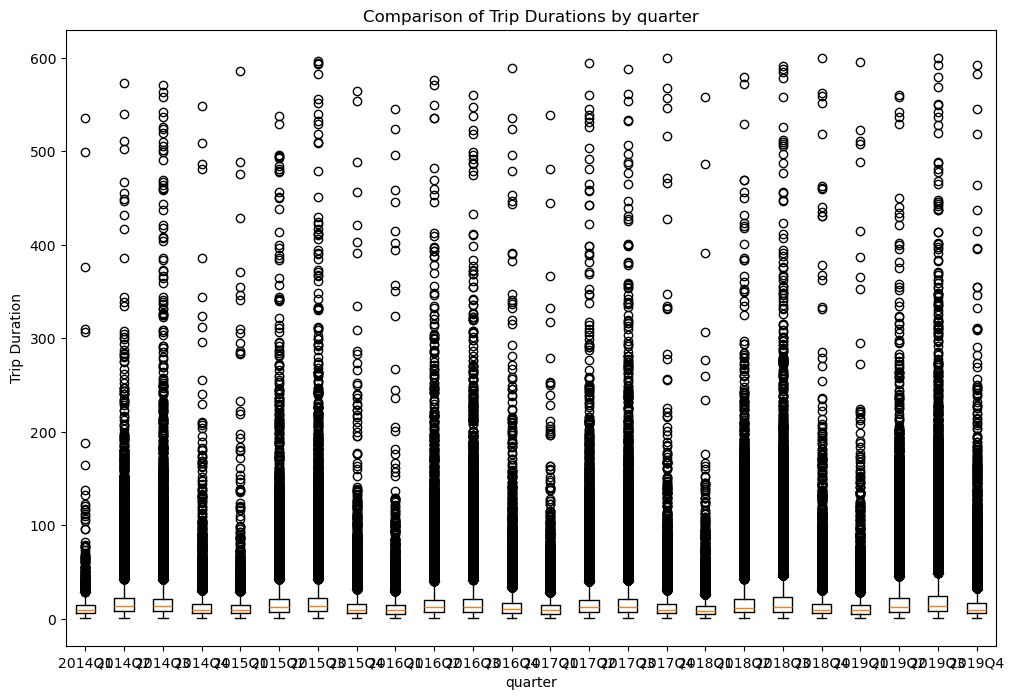

In [14]:

df_no_outliers = df_no_outliers.sort_values(['month_year'])
# Create a boxplot to compare the distribution of trip durations by year
plt.figure(figsize=(12, 8))
plt.boxplot([df_no_outliers[df_no_outliers['quarter'] == quarter]['trip_duration_min'] for quarter in df_no_outliers['quarter'].unique()], labels=df_no_outliers['quarter'].unique())
plt.title('Comparison of Trip Durations by quarter')
plt.xlabel('quarter')
plt.ylabel('Trip Duration')
plt.show()